In [9]:
import pandas as pd
import numpy as np

%pip install seaborn
import seaborn as sns

import matplotlib.pyplot as plt
%pip install tueplots
from tueplots import bundles


Note: you may need to restart the kernel to use updated packages.


In [2]:
results_2019 = pd.read_csv("../data/bac-results-2019.csv", index_col=0)
results_2020 = pd.read_csv("../data/bac-results-2020.csv", index_col=0)
results_2021 = pd.read_csv("../data/bac-results-2021.csv", index_col=0)

# convert to numeric what is possible
results_2019 = results_2019.apply(pd.to_numeric, errors='coerce').fillna(results_2019)
results_2020 = results_2020.apply(pd.to_numeric, errors='coerce').fillna(results_2020)
results_2021 = results_2021.apply(pd.to_numeric, errors='coerce').fillna(results_2021)

# replace NaNs with empty strings for easier searchability
results_2019.fillna('', inplace=True)
results_2020.fillna('', inplace=True)
results_2021.fillna('', inplace=True)

C:\Users\cseke\anaconda3\envs\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# column name abbreviations for non-final grades
ro1 = 'romanian_written'
mo1 = 'mother_tongue_written'
ma1 = 'mandatory_subject_written'
el1 = 'elective_subject_written'

# column name abbreviations for final grades
ro2 = 'romanian_written_final'
mo2 = 'mother_tongue_written_final'
ma2 = 'mandatory_subject_written_final'
el2 = 'elective_subject_written_final'

# remove invalid rows from the 2019 data (grade cell contains "DISQUALIFIED" etc. strings)
results_2019_2 = results_2019[results_2019[[ro1, mo1, ma1, el1, ro2, mo2, ma2, el2]].applymap(lambda x: np.isreal(x) or x == '').all(1)]

# combine the three years
results_all = pd.concat([results_2019_2, results_2020, results_2021], ignore_index=True, sort=False)

In [4]:
# separate dataset into romanians and minorities
romanian_only_results = results_all[results_all['mother_tongue'] == '']
romanian_plus_results = results_all[results_all['mother_tongue'] != '']

# prevent string errors
romanian_only_results.replace('', np.nan, inplace=True)
romanian_plus_results.replace('', np.nan, inplace=True)

# filter both for valid grades
ro_f = romanian_only_results[ \
    (romanian_only_results[ma2] >= 1.0) & \
    (romanian_only_results[el2] >= 1.0) & \
    (romanian_only_results[ro2] >= 1.0)].copy()
rp_f = romanian_plus_results[ \
    (romanian_plus_results[ma2] >= 1.0) & \
    (romanian_plus_results[el2] >= 1.0) & \
    (romanian_plus_results[mo2] >= 1.0) & \
    (romanian_plus_results[ro2] >= 1.0)].copy()

# calculate the total average
ro_f.loc[:, 'total_average'] = ro_f.loc[:, [ro2, ma2, el2]].mean(axis=1)
rp_f.loc[:, 'total_average'] = rp_f.loc[:, [ro2, ma2, el2, mo2]].mean(axis=1)

# calculate the average grade of their secialization (mandatory and elective subjects)
ro_f.loc[:, 'subject_average'] = ro_f.loc[:, [ma2, el2]].mean(axis=1)
rp_f.loc[:, 'subject_average'] = rp_f.loc[:, [ma2, el2]].mean(axis=1)

C:\Users\cseke\anaconda3\envs\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


C:\Users\cseke\anaconda3\envs\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


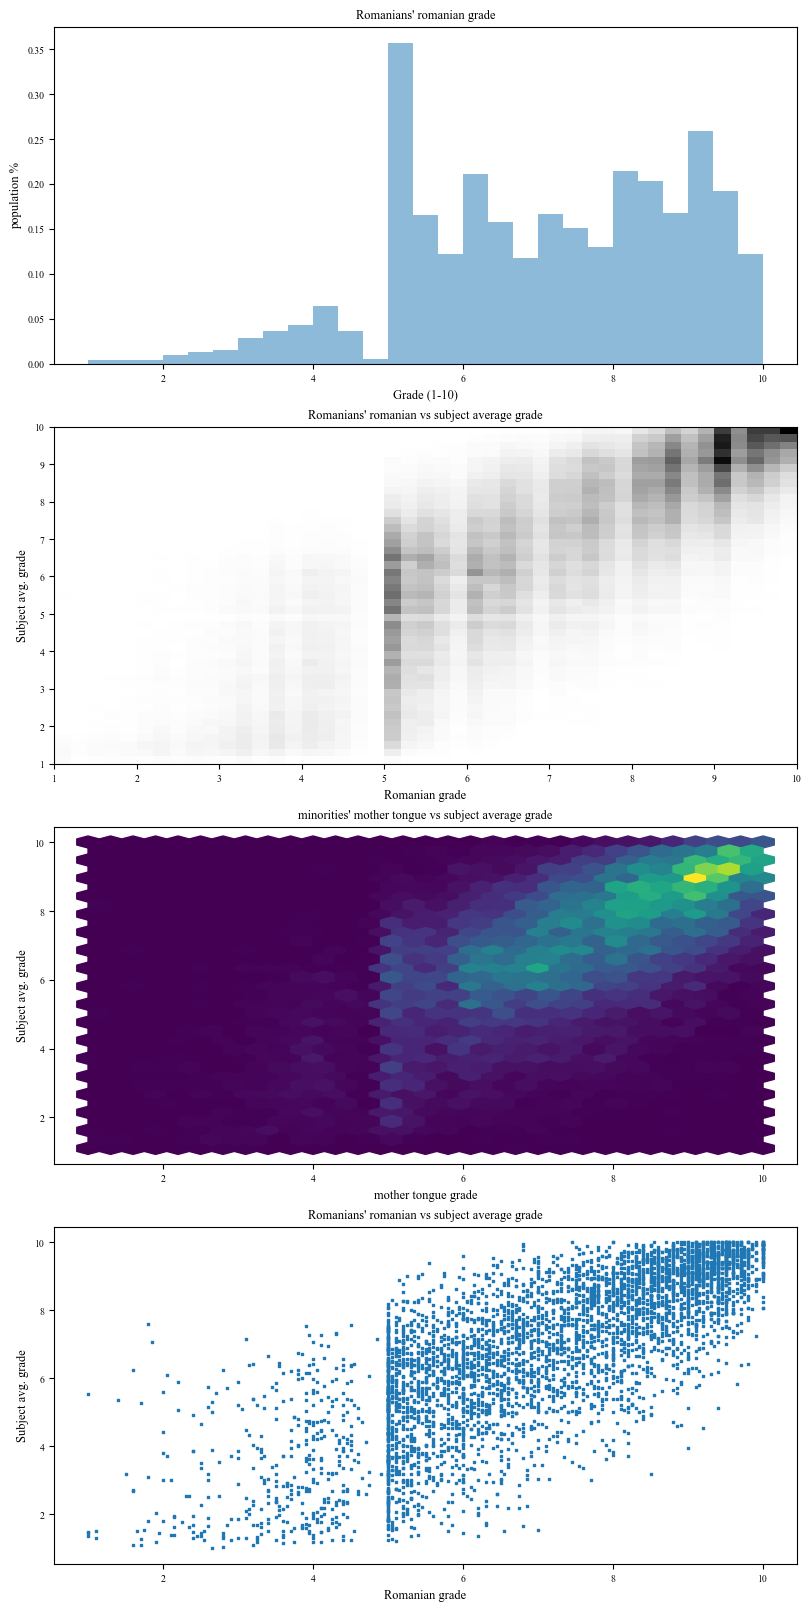

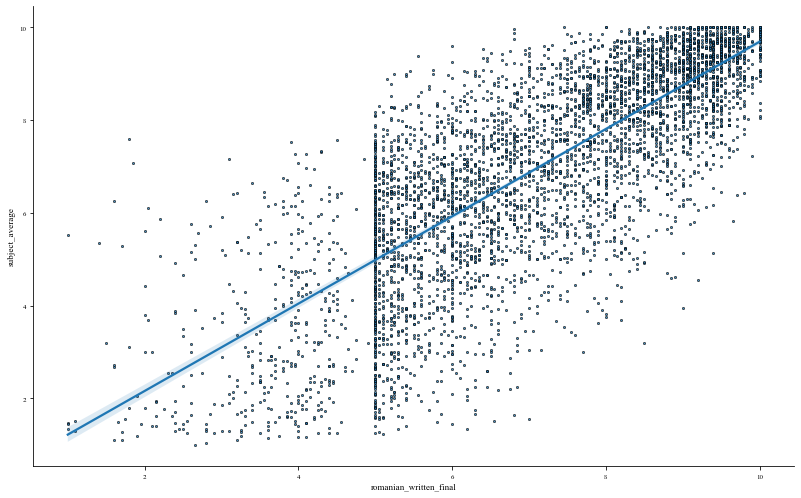

In [15]:
with plt.rc_context(bundles.neurips2021(usetex=False, family='serif')):
    fig, axs = plt.subplots(4, figsize=(8, 16), dpi=100)

    # plot 1: histogram of an exam grade
    axs[0].hist(ro_f['romanian_written_final'].to_list(), bins=27, density=True, alpha = 0.5)
    axs[0].set_title("Romanians' romanian grade")
    axs[0].set_xlabel('Grade (1-10)')
    axs[0].set_ylabel('population %')

    # plot 2: marginal histogram of romanian grade vs subject average
    axs[1].hist2d(ro_f['romanian_written_final'].to_list(), ro_f['subject_average'].to_list(), cmap='binary', bins=45)
    axs[1].set_title("Romanians' romanian vs subject average grade")
    axs[1].set_xlabel('Romanian grade')
    axs[1].set_ylabel('Subject avg. grade')

    # plot 3: almost same as plot 2, but on hexbin
    axs[2].hexbin(rp_f['mother_tongue_written_final'].to_list(), rp_f['subject_average'].to_list(), gridsize=30)
    axs[2].set_title("minorities' mother tongue vs subject average grade")
    axs[2].set_xlabel('mother tongue grade')
    axs[2].set_ylabel('Subject avg. grade')

    # plot 4 & 5: scatter plot of plot 2 data on a sample
    rof_sample = ro_f.sample(5000)

    axs[3].scatter(rof_sample['romanian_written_final'].to_list(), rof_sample['subject_average'].to_list(), cmap='Purples', marker=',', s=1)
    axs[3].set_title("Romanians' romanian vs subject average grade")
    axs[3].set_xlabel('Romanian grade')
    axs[3].set_ylabel('Subject avg. grade')

    grade_pairs = list(zip(rof_sample['romanian_written_final'].to_list(), rof_sample['subject_average'].to_list()))
    grade_pairs_df = pd.DataFrame(grade_pairs, columns=['romanian_written_final','subject_average'])
    gridobj = sns.lmplot(x="romanian_written_final", y="subject_average", data=grade_pairs_df, 
        height=7, aspect=1.6, robust=True, palette='tab10', scatter_kws=dict(s=5, linewidths=.7, edgecolors='black'))
    
    plt.show()
    
    # fig.savefig('figname_neurips.pdf', bbox_inches='tight')
    # this file can now by used as \includegraphics{filename}

C:\Users\cseke\anaconda3\envs\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


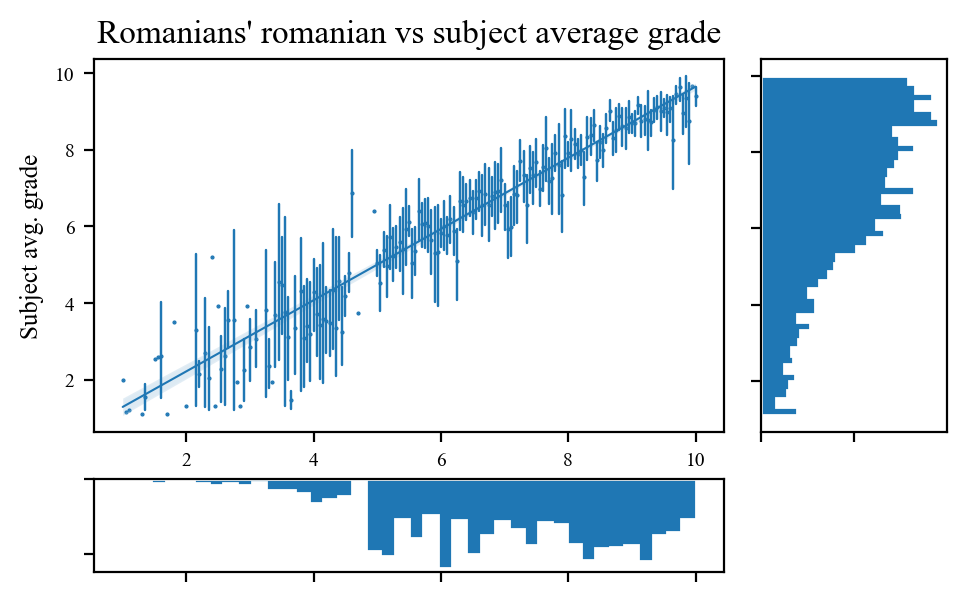

In [20]:
# scatter plot of a marginal with histogram side dishes

with plt.rc_context(bundles.neurips2021(usetex=False, family='serif')):
    # define the axes
    fig = plt.figure(dpi=200)
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
    ax_main = fig.add_subplot(grid[:-1, :-1])
    ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
    ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

    # data prep
    rof_sample = ro_f.sample(2000)
    grade_pairs = list(zip(rof_sample['romanian_written_final'].to_list(), rof_sample['subject_average'].to_list()))
    grade_pairs_df = pd.DataFrame(grade_pairs, columns=['romanian_written_final','subject_average'])

    # sns.scatter doesn't accept a predefined axis
    sns.set(style="ticks", rc={"lines.linewidth": 0.5})
    sns.regplot(x="romanian_written_final", y="subject_average", data=grade_pairs_df, ax=ax_main, marker='.', x_estimator=np.mean, scatter_kws={'s':1})

    # histogram on the right
    ax_bottom.hist(rof_sample['romanian_written_final'], 40, histtype='stepfilled', orientation='vertical')
    ax_bottom.invert_yaxis()

    # histogram in the bottom
    ax_right.hist(rof_sample['subject_average'], 40, histtype='stepfilled', orientation='horizontal')

    ax_main.set_title("Romanians' romanian vs subject average grade")
    ax_main.set_xlabel('Romanian grade')
    ax_main.set_ylabel('Subject avg. grade')

    plt.show()